In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds


In [ ]:
# Load dataset
file_path = '/content/drive/MyDrive/project/fashion_dataset.csv'
fashion_data = pd.read_csv(file_path)


In [ ]:
# Extract relevant columns: product ID and user IDs
user_interactions = fashion_data[['id', 'user_id1', 'user_id2', 'user_id3', 'user_id4', 'user_id5']]

# Melt user interaction columns to long format
user_item_interactions = user_interactions.melt(id_vars=['id'], value_name='user_id').dropna()

# Drop unnecessary 'variable' column
user_item_interactions = user_item_interactions.drop(columns=['variable'])

# Each row now represents an interaction between a user and a product (id)


In [ ]:
# Create a user-item interaction matrix
user_item_matrix = user_item_interactions.pivot_table(index='user_id', columns='id', aggfunc='size', fill_value=0)


In [ ]:
# Convert matrix to numpy array of type float
user_item_matrix = user_item_matrix.astype(float)

# Use SVD for matrix factorization with k=50 latent factors
U, sigma, Vt = svds(user_item_matrix, k=50)
sigma = np.diag(sigma)


In [ ]:
# Reconstruct the predicted user-item interaction matrix
predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Convert back to DataFrame for easier handling
predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=user_item_interactions['id'].unique())


In [ ]:
def recommend_products(user_id, num_recommendations=5):
    user_indices = user_item_interactions['user_id'].unique()

    # Check if user exists
    if user_id not in user_indices:
        return "User ID not found in dataset."

    user_idx = np.where(user_indices == user_id)[0][0]
    sorted_indices = np.argsort(predicted_ratings[user_idx])[::-1]
    recommended_product_ids = predicted_ratings_df.columns[sorted_indices][:num_recommendations]

    return recommended_product_ids.tolist()

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

def display_images(product_ids):
    # Get image links for the recommended products
    product_data = fashion_data[fashion_data['id'].isin(product_ids)][['id', 'link']]

    # Create a grid of subplots with one row and the number of columns equal to the number of product IDs
    plt.figure(figsize=(15, 5))

    for idx, row in enumerate(product_data.itertuples()):
        response = requests.get(row.link)
        img = Image.open(BytesIO(response.content))

        # Plot each image in the subplot
        plt.subplot(1, len(product_ids), idx + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Product ID: {row.id}")

    plt.show()




Recommended product IDs: [34391, 37272, 20384, 13206, 25918]


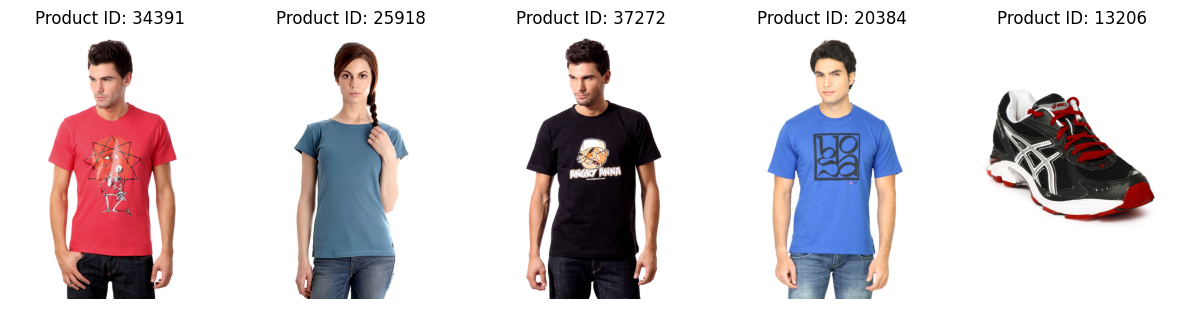

In [ ]:
# Example call to display images
user_id = 93810
recommendations = recommend_products(user_id, num_recommendations=5)
print("Recommended product IDs:", recommendations)

# Display images of recommended products
display_images(recommendations)

Recommended product IDs: [50815, 20544, 11276, 5836, 17541]


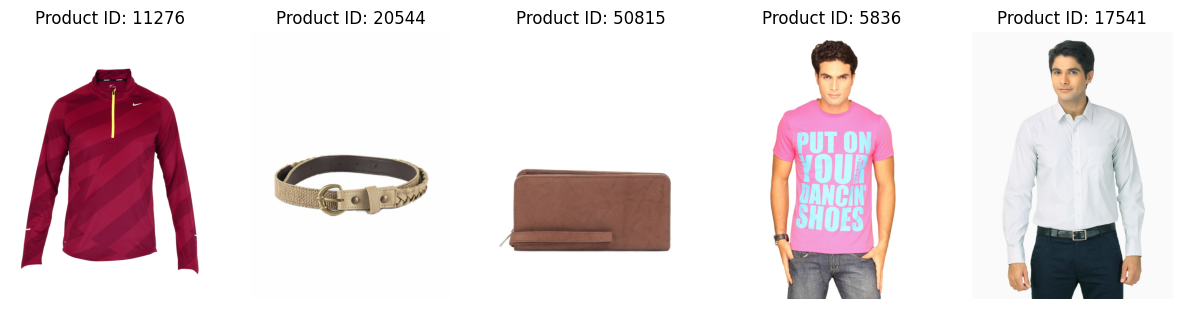

In [ ]:
# Example call to display images
user_id = 13905
# Ensure recommendations is a list of product IDs
recommendations = recommend_products(user_id, num_recommendations=5)

# If recommendations is a string, convert it to a list (if needed)
if isinstance(recommendations, str):
    recommendations = recommendations.split(',')  # Assuming it's a comma-separated string

# Display the recommended products' images
print("Recommended product IDs:", recommendations)
display_images(recommendations)
